# Read in libraries and set up plotting tools

In [494]:
# edit section below to change how we plot the maze predictions
import os
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.patches import Rectangle, Arrow, Circle
import matplotlib
import json
import pandas as pd
import numpy as np
import random
from vgc_project.dynamic_vgc import dynamic_vgc
from vgc_project.soft_vgc import soft_value_guided_construal
from vgc_project.construal_search import \
    ConstrualSearch, ExhaustiveSearch, EventListener, BoundedDepthFirstSearch

os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/vgc_project/vgc_project/')

matplotlib.rcParams['pdf.fonttype'] = 42

mediumblue = np.array(to_rgb('#EB611D'))
gainsboro = np.array(to_rgb('#D7E0E3'))

def value_format(val):
    if val == 0:
        return "0.0"
    elif 0 < val < 1:
        ret =  f"{val:.2f}".lstrip("0")
        if ret == ".00":
            return "0.0"
        elif ret == "1.00":
            return "1.0"
        else:
            return ret
    elif val >= 1:
        return f"{val:.1f}"
    else:
        raise

def calc_obstacle_label_loc(locs, tile_array):
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    locs = np.array(locs) + .5
    mean_loc = np.mean(locs, axis=0)
    obs_bbox_center = np.mean([
        [locs[:,0].min(), locs[:, 1].min()],
        [locs[:,0].max(), locs[:, 1].max()]
    ], axis=0)
    agg_loc = mean_loc*.6 + obs_bbox_center*.4
    agg_loc = (
        min(max(1, agg_loc[0]), grid_w - 1),
        min(max(1, agg_loc[1]), grid_h - 1)
    )
    return agg_loc

def color_mix(v, alpha=12):
    w = 1/(1 + np.exp(-alpha*(v-.5)))
    return (1-w)*gainsboro + w*mediumblue
    
def plot_grid_obstacle_VGC(
    tile_array,
    ax,
    feature_colors,
    obstacle_values,
    value_range,
    ax_pad=.25/4,
    color_mix_alpha=12,
    grid_lineweight=.25,
    invert_color=False
):
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    #for side in ['top','right','bottom','left']:
        #ax.spines[side].set_visible(False)
    ax.tick_params(axis='both',which='both',labelbottom=False,bottom=False, left=False, labelleft=False)
    ax.set_xlim(-ax_pad, grid_w+ax_pad)
    ax.set_ylim(-ax_pad, grid_h+ax_pad)
    ax.set_aspect('equal')
    square = Rectangle(
        (0, 0),
        grid_w, grid_h,
        color='w',
        ec='k', 
        lw=grid_lineweight
    )
    ax.add_patch(square)
    
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    obstacle_locs = {o: [] for o in obstacle_values}
    for x, y in product(range(grid_w), range(grid_h)):
        loc_feature = tile_array[grid_h - y - 1][x]
        if loc_feature in "012345":
            obs_value = obstacle_values[loc_feature]
            norm_value = (obs_value - value_range[0])/(value_range[1] - value_range[0])
            if invert_color:
                norm_value = 1 - norm_value
            loc_color = color_mix(norm_value, alpha=color_mix_alpha)
            obstacle_locs[loc_feature].append((x, y))
        elif loc_feature in feature_colors:
            loc_color = feature_colors[loc_feature]
        else:
            loc_color = '#FFFFFF'
        square = Rectangle(
            (x, y),
            1, 1,
            color=loc_color,
            ec='grey', 
            lw=grid_lineweight
        )
        ax.add_patch(square)
        
        if loc_feature == "S":
            ax.plot(
                x + .4, y + .5,
                markeredgecolor='#E330A4',
                markerfacecolor='#E330A4',
                marker='o',
                markersize=4.5,
                markeredgewidth=.5,
                fillstyle='full'
            )
        elif loc_feature == "G":
            goal =ax.plot(
                x + .5, y + .5,
                markeredgecolor='green',
                markerfacecolor='green',
                marker='*',
                markersize=6,
                markeredgewidth=0.5,
                fillstyle='full'
            )

        
def plot_grid_obstacle_dVGC(
    tile_array,
    ax,
    feature_colors,
    obstacle_values,
    value_range,
    ax_pad=.25/4,
    color_mix_alpha=12,
    grid_lineweight=.25,
    invert_color=False
):
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    #for side in ['top','right','bottom','left']:
        #ax.spines[side].set_visible(False)
    ax.tick_params(axis='both',which='both',labelbottom=False,bottom=False, left=False, labelleft=False)
    ax.set_xlim(-ax_pad, grid_w+ax_pad)
    ax.set_ylim(-ax_pad, grid_h+ax_pad)
    ax.set_aspect('equal')
    square = Rectangle(
        (0, 0),
        grid_w, grid_h,
        color='w',
        ec='k', 
        lw=grid_lineweight
    )
    ax.add_patch(square)
    
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    obstacle_locs = {o: [] for o in obstacle_values}
    for x, y in product(range(grid_w), range(grid_h)):
        loc_feature = tile_array[grid_h - y - 1][x]
        if loc_feature in "012345":
            obs_value = obstacle_values[loc_feature]
            norm_value = (obs_value - value_range[0])/(value_range[1] - value_range[0])
            if invert_color:
                norm_value = 1 - norm_value
            loc_color = color_mix(norm_value, alpha=color_mix_alpha)
            obstacle_locs[loc_feature].append((x, y))
        elif loc_feature in feature_colors:
            loc_color = feature_colors[loc_feature]
        else:
            loc_color = '#FFFFFF'
        square = Rectangle(
            (x, y),
            1, 1,
            color=loc_color,
            ec='grey', 
            lw=grid_lineweight
        )
        ax.add_patch(square)
        
        if loc_feature == "S":
            ax.plot(
                x + .4, y + .5,
                markeredgecolor='#E330A4',
                markerfacecolor='#E330A4',
                marker='o',
                markersize=4.5,
                markeredgewidth=.5,
                fillstyle='full'
            )
        elif loc_feature == "G":
            goal =ax.plot(
                x + .5, y + .5,
                markeredgecolor='green',
                markerfacecolor='green',
                marker='*',
                markersize=6,
                markeredgewidth=0.5,
                fillstyle='full'
            )
            #ax.add_patch(goal)
    for obstacle, locs in obstacle_locs.items():
        label_loc = calc_obstacle_label_loc(locs, tile_array)
        text = ax.text(
                  label_loc[0],
                label_loc[1],
                value_format(obstacle_values[obstacle]),
                color='k',
                ha='center',
                va='center_baseline',
                bbox=dict(facecolor='#FEE5D6', edgecolor='#EB611D', linewidth=.5, boxstyle='round,pad=.2'),
                fontdict=dict(font="Arial"),
        )
        text.set_fontsize(5)

#  Read in mazes json files

In [495]:
# read in mazes which are stored as json files
os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/vgc_project/vgc_project/')
mazes = {
    **json.load(open("../../experiments/mazes/mazesfinal/mazes_Lateralized.json", 'r'))
}

os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/results/')

# Iterate through mazes to compute STATIC VGC

In [496]:
from vgc_project.vgc import value_guided_construal

data = []
for maze_name in mazes.keys():
    #print(maze_name)
    VGC_temp=value_guided_construal(tile_array=tuple(mazes[maze_name]),
                           construal_inverse_temp =1/0.1, 
                           feature_rewards=(("G", 0), ),
                           absorbing_features=("G",), 
                           wall_features="#0123456789", 
                           default_features=(".",),
                           initial_features=("S",),
                           step_cost=-1, 
                           discount_rate=1.0-1e-5, 
                           planning_alg="policy_iteration")
    myKeys = list(VGC_temp['obstacle_probs'].keys())
    myKeys.sort()
    sorted_dict = {i: VGC_temp['obstacle_probs'][i] for i in myKeys}
    data.extend(list(sorted_dict.values()))
    
    #df_new_rows= pd.DataFrame.from_dict(sorted_dict, orient='index')
    #df = pd.concat([df, df_new_rows])
    
df = pd.DataFrame(data)
df.columns =['static_vgc_weight']
df.insert(0, "grid", np.repeat(list(mazes.keys()), 6), True)
df.insert(1, "obstacle", ['obs-0', 'obs-1', 'obs-2', 'obs-3', 'obs-4', 'obs-5']*len(mazes.keys()), True)


# Now let us add in dynamic VGC to the dataframe

In [497]:

data = []
for maze_name in mazes.keys():
    dVGC_temp= dynamic_vgc(tile_array=tuple(mazes[maze_name]),
                        ground_policy_inv_temp=1/0.1,
                        ground_policy_rand_choose=0.,
                        ground_discount_rate=1.0-1e-5,
                        action_deviation_reward=0,
                        wall_bias=0.,
                        wall_bump_cost=0.,
                        added_obs_cost=1,
                        removed_obs_cost=0,
                        continuing_obs_cost=0,
                        construal_switch_cost=0,
                        switching_inv_temp=5,
                        switching_rand_choose=0.,
                        switching_discount_rate=1-1e-5,
                        max_construal_size=3,
                        n_simulations=1000,
                        seed=112893)
    myKeys = list(dVGC_temp['obs_prob'].keys())
    myKeys.sort()
    sorted_dict = {i: dVGC_temp['obs_prob'][i] for i in myKeys}
    data.extend(list(sorted_dict.values()))
    
df.insert(3, "dynamic_vgc_weight", data, True)

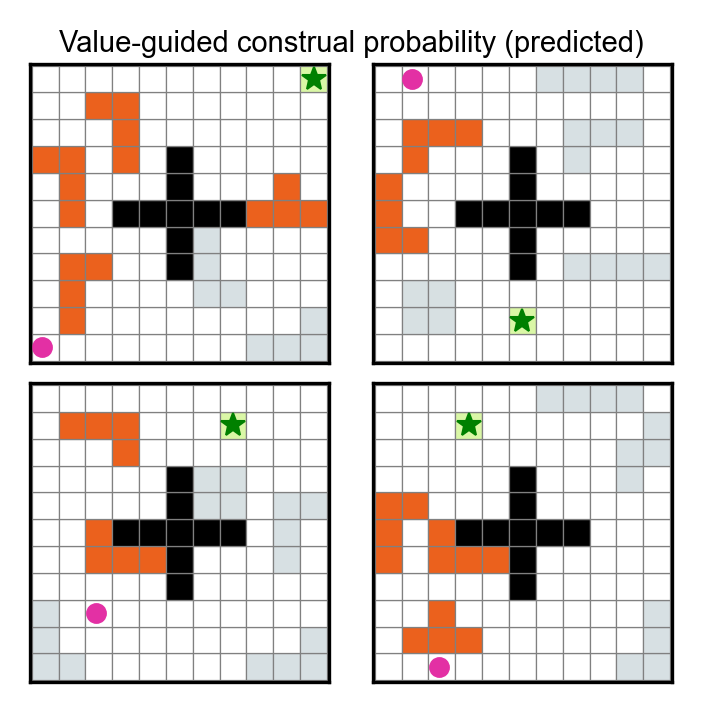

In [498]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [0, 1, 2, 3] # pick which models to plot
to_plot = df[df["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'static_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_VGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Lateralized_maze_1-4_sVGC.pdf")

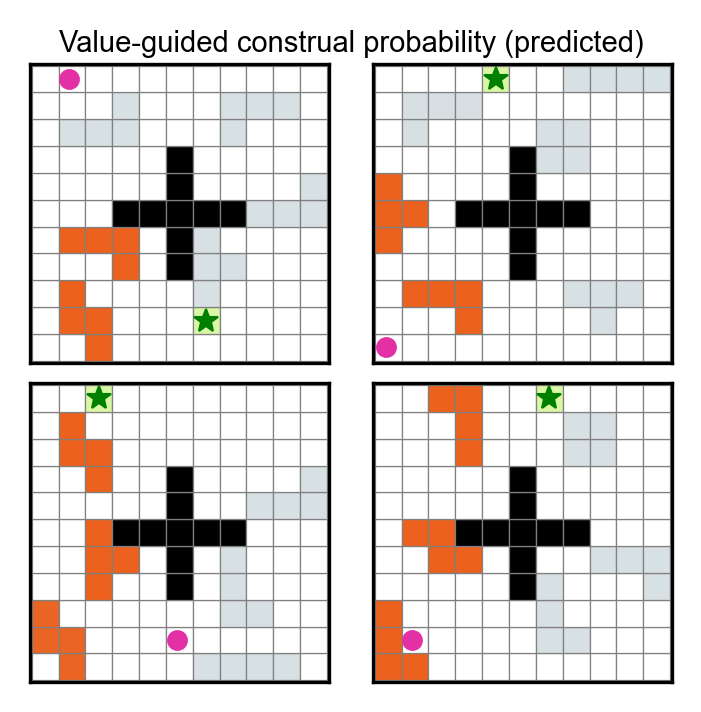

In [499]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [4, 5, 6, 7] # pick which models to plot
to_plot = df[df["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'static_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_VGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Lateralized_maze_5-8_sVGC.pdf")

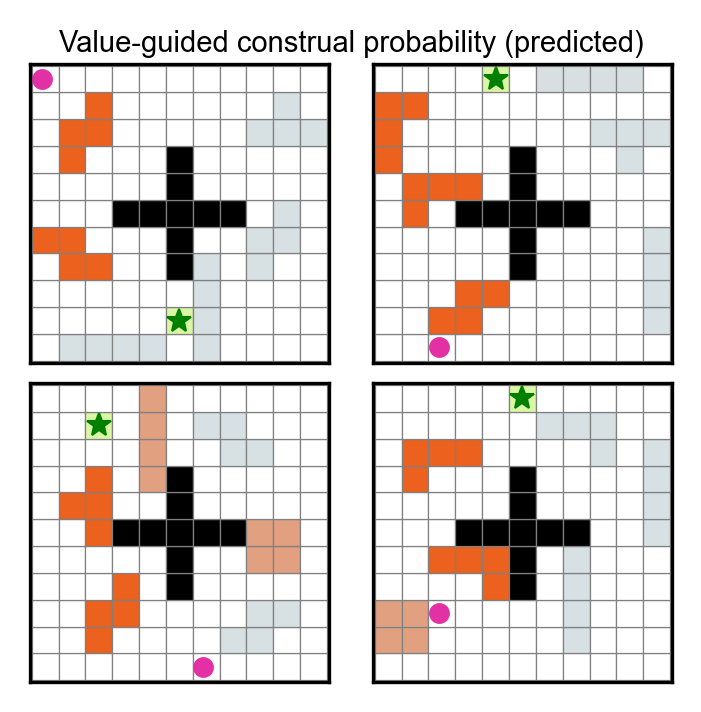

In [500]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [8, 9, 10, 11] # pick which models to plot
to_plot = df[df["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'static_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_VGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Lateralized_maze_9-12_sVGC.pdf")

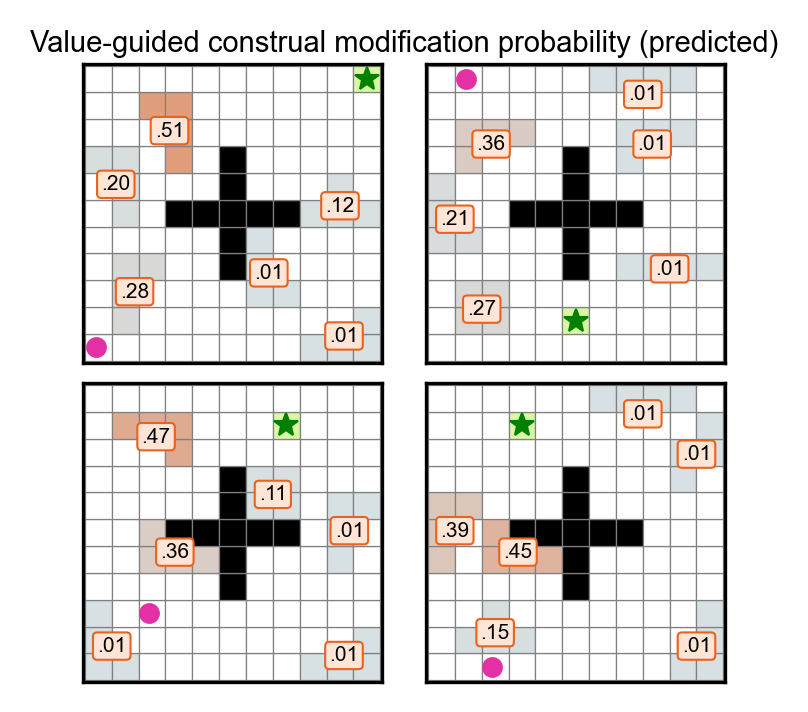

In [501]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [0, 1, 2, 3] # pick which models to plot
to_plot = df[df["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Lateralized_maze_1-4_dVGC.pdf")

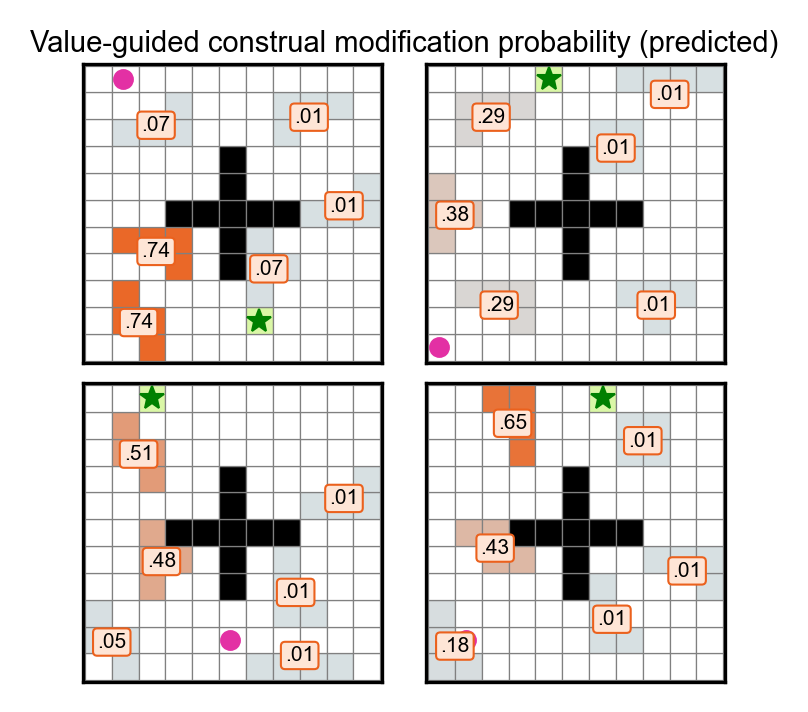

In [502]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [4, 5, 6, 7] # pick which models to plot
to_plot = df[df["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Lateralized_maze_5-8_dVGC.pdf")

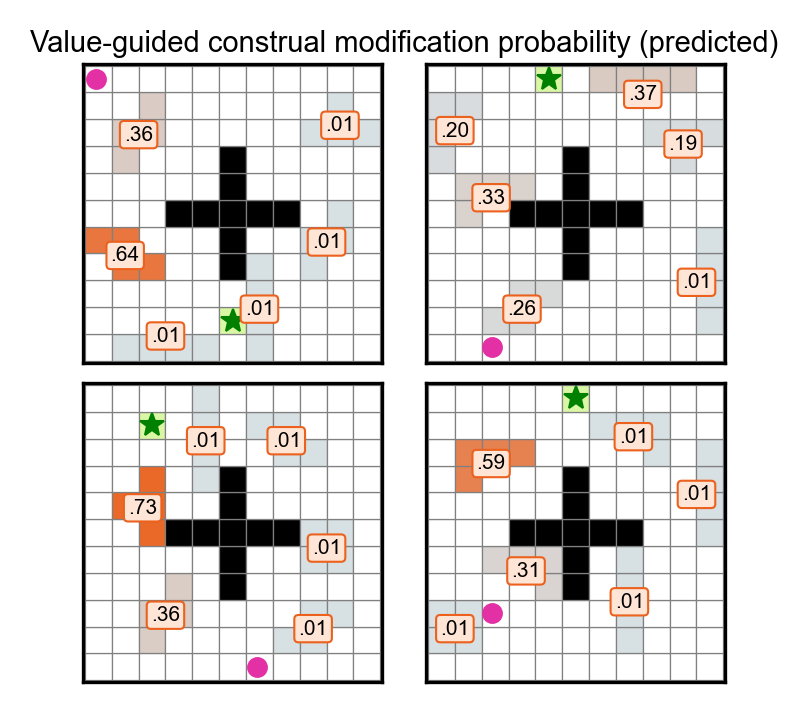

In [503]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [8, 9, 10, 11] # pick which models to plot
to_plot = df[df["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Lateralized_maze_9-12_dVGC.pdf")

# Let's look at non-lateralized stimuli

In [504]:
# read in mazes which are stored as json files
os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/vgc_project/vgc_project/')
mazes = {
    **json.load(open("../../experiments/mazes/mazesfinal/mazes_Nonlateralized.json", 'r'))
}

os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/results/')

In [505]:
from vgc_project.vgc import value_guided_construal

data = []
for maze_name in mazes.keys():
    VGC_temp=value_guided_construal(tile_array=tuple(mazes[maze_name]),
                           construal_inverse_temp =1/0.1, 
                           feature_rewards=(("G", 0), ),
                           absorbing_features=("G",), 
                           wall_features="#0123456789", 
                           default_features=(".",),
                           initial_features=("S",),
                           step_cost=-1, 
                           discount_rate=1.0-1e-5, 
                           planning_alg="policy_iteration")
    myKeys = list(VGC_temp['obstacle_probs'].keys())
    myKeys.sort()
    sorted_dict = {i: VGC_temp['obstacle_probs'][i] for i in myKeys}
    data.extend(list(sorted_dict.values()))
    
    #df_new_rows= pd.DataFrame.from_dict(sorted_dict, orient='index')
    #df = pd.concat([df, df_new_rows])
    
df_nl = pd.DataFrame(data)
df_nl.columns =['static_vgc_weight']
df_nl.insert(0, "grid", np.repeat(list(mazes.keys()), 6), True)
df_nl.insert(1, "obstacle", ['obs-0', 'obs-1', 'obs-2', 'obs-3', 'obs-4', 'obs-5']*len(mazes.keys()), True)


data = []
for maze_name in mazes.keys():
    dVGC_temp= dynamic_vgc(tile_array=tuple(mazes[maze_name]),
                        ground_policy_inv_temp=1/0.1,
                        ground_policy_rand_choose=0.,
                        ground_discount_rate=1.0-1e-5,
                        action_deviation_reward=0,
                        wall_bias=0.,
                        wall_bump_cost=0.,
                        added_obs_cost=1,
                        removed_obs_cost=0,
                        continuing_obs_cost=0,
                        construal_switch_cost=0,
                        switching_inv_temp=5,
                        switching_rand_choose=0.,
                        switching_discount_rate=1-1e-5,
                        max_construal_size=3,
                        n_simulations=1000,
                        seed=112893)
    myKeys = list(dVGC_temp['obs_prob'].keys())
    myKeys.sort()
    sorted_dict = {i: dVGC_temp['obs_prob'][i] for i in myKeys}
    data.extend(list(sorted_dict.values()))
    
df_nl.insert(3, "dynamic_vgc_weight", data, True)

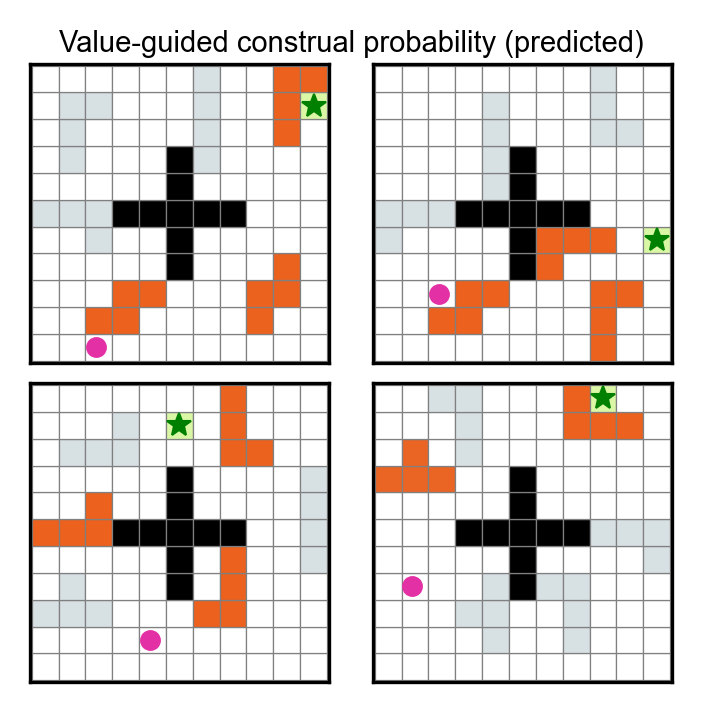

In [506]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [0, 1, 2, 3] # pick which models to plot
to_plot = df_nl[df_nl["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'static_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df_nl.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_VGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Nonlateralized_maze_1-4_sVGC.pdf")

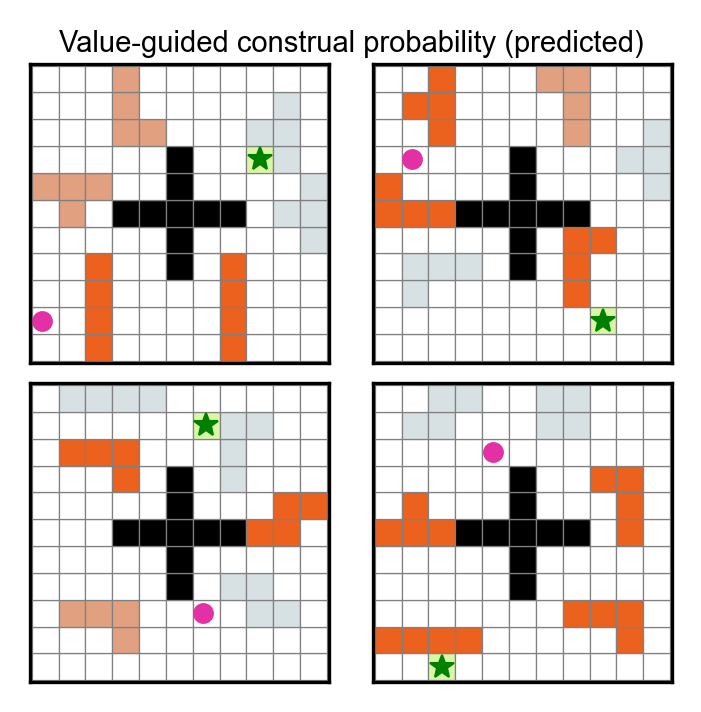

In [507]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [4, 5, 6, 7] # pick which models to plot
to_plot = df_nl[df_nl["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'static_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df_nl.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_VGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Nonlateralized_maze_5-8_sVGC.pdf")

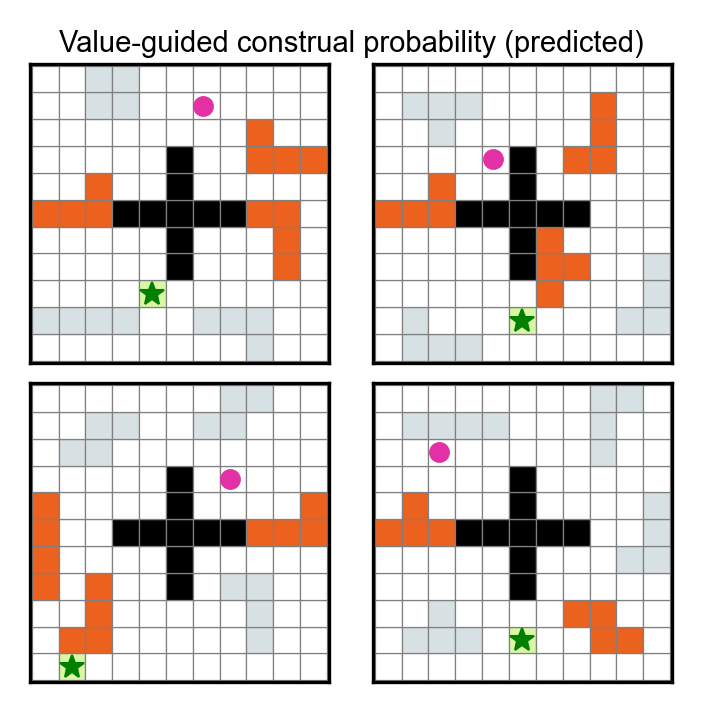

In [508]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [8, 9, 10, 11] # pick which models to plot
to_plot = df_nl[df_nl["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'static_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df_nl.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_VGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Nonlateralized_maze_9-12_sVGC.pdf")

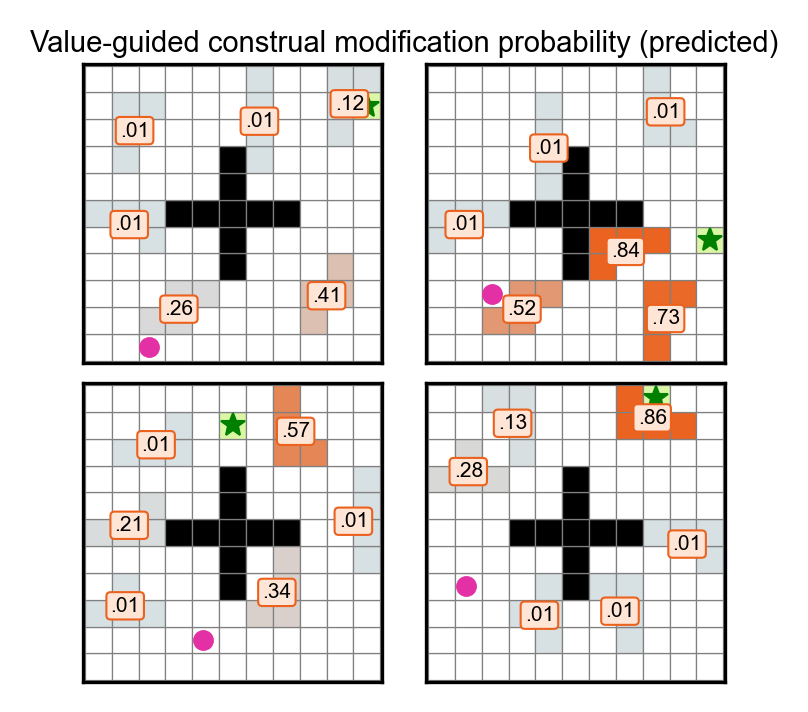

In [509]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [0, 1, 2, 3] # pick which models to plot
to_plot = df_nl[df_nl["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df_nl.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Nonlateralized_maze_1-4_dVGC.pdf")

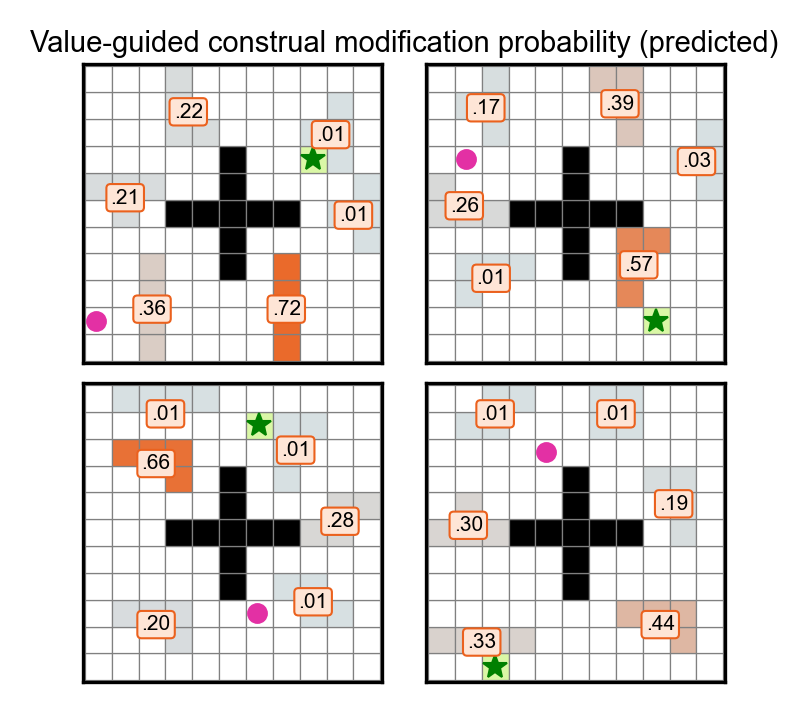

In [510]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [4, 5, 6, 7] # pick which models to plot
to_plot = df_nl[df_nl["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df_nl.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Nonlateralized_maze_5-8_dVGC.pdf")

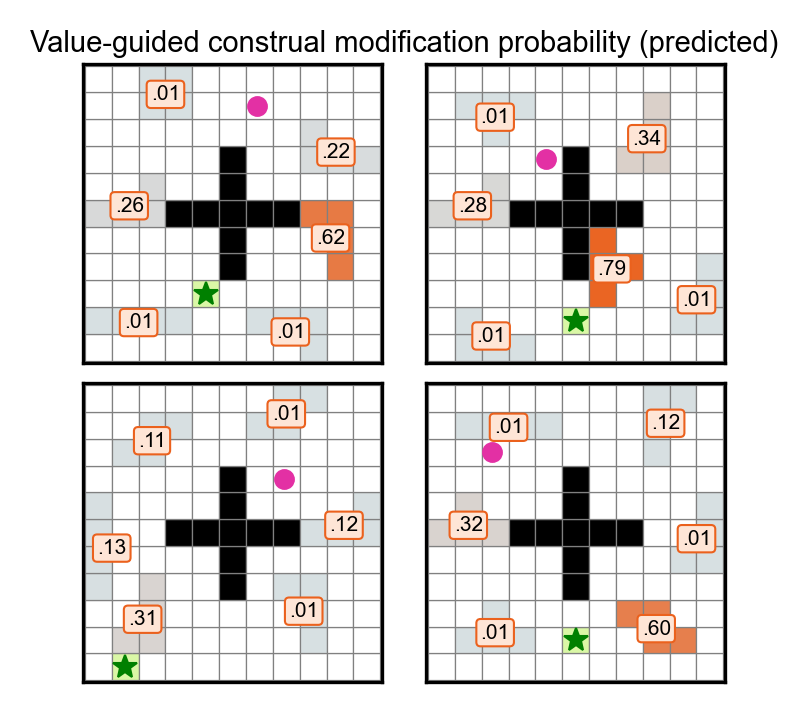

In [511]:
# model predictions
# create figure
fig_width_mm = 60
fig_height_mm = 60
mm_to_inch = 1/25.4 

assert fig_width_mm <= 182
assert fig_height_mm <= 245

import matplotlib.gridspec as gridspec
    
grids_to_plot = [8, 9, 10, 11] # pick which models to plot
to_plot = df_nl[df_nl["grid"].apply(lambda gn: int(gn.split('-')[1]) in grids_to_plot)]
n_grids = len(grids_to_plot)
ncols = 2
nrows = n_grids // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
    dpi=300
)
axes = list(axes.flatten())
measure = 'dynamic_vgc_weight'

for gridname, rows in to_plot.groupby('grid'):
    grid_means = df_nl.merge(pd.DataFrame({'grid': [gridname]}))
    obstacle_values = dict(zip(grid_means['obstacle'].apply(lambda o: o.split('-')[-1]), grid_means[measure]))
    ax = axes.pop(0)
    plot_grid_obstacle_dVGC(
        tile_array=mazes[gridname],
        ax=ax,
        feature_colors={"#": "k", "G": "#DAF7A6"},
        obstacle_values=obstacle_values,
        value_range=(0, 1),
        grid_lineweight=.30
    )
suptitle = plt.suptitle("Value-guided construal modification probability (predicted)", font="Arial", y=.95)
suptitle.set_fontsize(7)
plt.tight_layout(pad=.5)
fig.savefig("Nonlateralized_maze_9-12_dVGC.pdf")

#  Now let us check if heuristics differ between the later & non-lat mazes

In [512]:

# read in mazes which are stored as json files
os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/vgc_project/vgc_project/')
mazes = {
    **json.load(open("../../experiments/mazes/mazesfinal/mazes_Lateralized.json", 'r')),
    **json.load(open("../../experiments/mazes/mazesfinal/mazes_Nonlateralized.json", 'r'))
}

os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/results/')

goal = []
start = []
wall = []
center = []
moves = []

from vgc_project import maze_stats
from vgc_project.maze_stats import maze_obstacle_statistics
for maze_name in mazes.keys():
    maze_obs_stats=maze_obstacle_statistics(tile_array=tuple(mazes[maze_name]),
                                            n_simulations=1000,
                                            feature_rewards=(("G", 0), ),
                                            absorbing_features=("G",),
                                            wall_features="#0123456789",
                                            default_features=(".",),
                                            initial_features=("S",),
                                            step_cost=-1,
                                            discount_rate=1.0)
    myKeys = list(maze_obs_stats['goal_mindist'].keys())
    myKeys.sort()
    sorted_dict = {i: maze_obs_stats['goal_mindist'][i] for i in myKeys}
    goal.extend(list(sorted_dict.values()))
    sorted_dict = {i: maze_obs_stats['start_mindist'][i] for i in myKeys}
    start.extend(list(sorted_dict.values()))
    sorted_dict = {i: maze_obs_stats['walls_mindist'][i] for i in myKeys}
    wall.extend(list(sorted_dict.values()))
    sorted_dict = {i: maze_obs_stats['center_mindist'][i] for i in myKeys}
    center.extend(list(sorted_dict.values()))
    moves.extend(np.repeat(maze_obs_stats['Min_num_moves'],6))
    print(maze_obs_stats['Min_num_moves'])
    
    #df_new_rows= pd.DataFrame.from_dict(sorted_dict, orient='index')
    #df = pd.concat([df, df_new_rows])
    
    
maze_stats_df= pd.DataFrame(goal)
maze_stats_df.columns =['goal_dist']
maze_stats_df.insert(0, "grid", np.repeat(list(mazes.keys()), 6), True)
maze_stats_df.insert(1, "obstacle", ['obs-0', 'obs-1', 'obs-2', 'obs-3', 'obs-4', 'obs-5']*len(mazes.keys()), True)
maze_stats_df.insert(3, "start_dist", start, True)
maze_stats_df.insert(4, "wall_dist", wall, True)
maze_stats_df.insert(5, "center_dist", center, True)
maze_stats_df.insert(6, "lateralized", np.repeat(list([1,0]), 6*12), True)
maze_stats_df.insert(7, "dVGC", list(df['dynamic_vgc_weight']) + list(df_nl['dynamic_vgc_weight']), True)
maze_stats_df.insert(8, "sVGC", list(df['static_vgc_weight']) + list(df_nl['static_vgc_weight']), True)
maze_stats_df.insert(8, "Moves", moves, True)


# save to csv for plotting in R
maze_stats_df.to_csv('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/newLAT_mazes_stats.csv')

21
18
15
21
17
15
17
17
15
21
18
14
18
17
16
19
19
18
16
19
18
16
18
17


In [513]:
# permutation t-test indepn samples, two tailed, to test for diff between lateralized vs non-lateralized 
import scipy
print(scipy.stats.ttest_ind(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "Moves"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "Moves"],
                     equal_var=True, permutations=1000, random_state=None, alternative='two-sided'))

print(scipy.stats.ttest_ind(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "goal_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "goal_dist"],
                     equal_var=True, permutations=1000, random_state=None, alternative='two-sided'))

print(scipy.stats.ttest_ind(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "start_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "start_dist"],
                     equal_var=True, permutations=1000, random_state=None, alternative='two-sided'))

print(scipy.stats.ttest_ind(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "wall_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "wall_dist"],
                     equal_var=True, permutations=1000, random_state=None, alternative='two-sided'))

print(scipy.stats.ttest_ind(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "center_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "center_dist"],
                     equal_var=True, permutations=1000, random_state=None, alternative='two-sided'))

TtestResult(statistic=-0.5313249128563998, pvalue=0.6463536463536463, df=nan)
TtestResult(statistic=0.9070320194186664, pvalue=0.37962037962037964, df=nan)
TtestResult(statistic=1.8397270862606971, pvalue=0.07392607392607392, df=nan)
TtestResult(statistic=0.9940110545650319, pvalue=0.32967032967032966, df=nan)
TtestResult(statistic=0.7668871928312614, pvalue=0.4805194805194805, df=nan)


In [514]:
print(scipy.stats.pearsonr(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "goal_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "dVGC"]))
print(scipy.stats.pearsonr(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "start_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "dVGC"]))
print(scipy.stats.pearsonr(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "wall_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "dVGC"]))
print(scipy.stats.pearsonr(maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "center_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==1, "dVGC"]))

PearsonRResult(statistic=-0.27748814752722717, pvalue=0.018279664292527045)
PearsonRResult(statistic=-0.22077054360967346, pvalue=0.06238060560603416)
PearsonRResult(statistic=-0.15139615547282342, pvalue=0.20426708965883134)
PearsonRResult(statistic=-0.14748417822879203, pvalue=0.21634095443108428)


In [515]:
print(scipy.stats.pearsonr(maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "goal_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "dVGC"]))
print(scipy.stats.pearsonr(maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "start_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "dVGC"]))
print(scipy.stats.pearsonr(maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "wall_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "dVGC"]))
print(scipy.stats.pearsonr(maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "center_dist"], 
                     maze_stats_df.loc[maze_stats_df["lateralized"] ==0, "dVGC"]))

PearsonRResult(statistic=-0.29183908922967866, pvalue=0.012867926927023883)
PearsonRResult(statistic=0.027989979215705153, pvalue=0.8154570990167329)
PearsonRResult(statistic=-0.2149844202302111, pvalue=0.06974759483308912)
PearsonRResult(statistic=-0.24809237808852516, pvalue=0.03561789332220376)


In [516]:
# read in mazes which are stored as json files
os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/vgc_project/vgc_project/')
mazes = {
    **json.load(open("../../experiments/mazes/mazesfinal/mazes_Lateralized.json", 'r'))
}

os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/results/')

heu_graph = []
heu_sr = []
heu_bottle = []
heu_traj = []

from vgc_project.heuristic_search import graph_based_heuristic_search
from vgc_project.successor_rep import optimal_bottleneck
from vgc_project.successor_rep import successor_representation
from vgc_project.heuristic_search import trajectory_based_heuristic_search

for maze_name in mazes.keys():
    print(maze_name)
    heutristic_graph= graph_based_heuristic_search(tile_array=tuple(mazes[maze_name]),
                                                    seed=1111,
                                                    n_simulations=100,
                                                    heuristic_type= 'no_obstacles',
                                                    feature_rewards=(("G", 0), ),
                                                    absorbing_features=("G",),
                                                    wall_features="#012345",
                                                    default_features=(".",),
                                                    initial_features=("S",),
                                                    step_cost=-1,
                                                    discount_rate=1.0)
    myKeys = list(heutristic_graph['mean_hit_counts'].keys())
    myKeys.sort()
    sorted_dict = {i: heutristic_graph['mean_hit_counts'][i] for i in myKeys}
    heu_graph.extend(list(sorted_dict.values())[0:6])
    
    heutristic_sr=successor_representation(tile_array=tuple(mazes[maze_name]),
                                                feature_rewards=(("G", 0), ),
                                                absorbing_features=("G",),
                                                wall_features="#012345",
                                                default_features=(".",),
                                                initial_features=("S",),
                                                step_cost=-1,
                                                discount_rate=1.0)

    myKeys = list(heutristic_sr['obstacle_occupancy'].keys())
    myKeys.sort()
    sorted_dict = {i: heutristic_sr['obstacle_occupancy'][i] for i in myKeys}
    heu_sr.extend(list(sorted_dict.values())[1:7])
    
    #heutristic_bottle=optimal_bottleneck(tile_array=tuple(mazes[maze_name]),
                                                #feature_rewards=(("G", 0), ),
                                                #absorbing_features=("G",),
                                                #wall_features="#012345",
                                                #default_features=(".",),
                                                #initial_features=("S",),
                                                #step_cost=-1,
                                                #discount_rate=1.0)
    #myKeys = list(heutristic_bottle['min_general_bottleneck_distances'].keys())
    #myKeys.sort() # h
    #sorted_dict = {i: heutristic_bottle['min_general_bottleneck_distances'][i] for i in myKeys}
    #heu_bottle.extend(list(sorted_dict.values())[1:7])
    
    heutristic_traj=trajectory_based_heuristic_search(tile_array=tuple(mazes[maze_name]),
                                                    seed=1111,
                                                    n_simulations=1000,
                                                    heuristic_type= 'no_obstacles',
                                                    feature_rewards=(("G", 0), ),
                                                    absorbing_features=("G",),
                                                    wall_features="#012345",
                                                    default_features=(".",),
                                                    initial_features=("S",),
                                                    step_cost=-1,
                                                    discount_rate=1.0)
    myKeys = list(heutristic_traj['mean_hit_counts'].keys())
    myKeys.sort() #hh
    sorted_dict = {i: heutristic_traj['mean_hit_counts'][i] for i in myKeys}
    heu_traj.extend(list(sorted_dict.values())[0:6])

    
    
    
maze_stats_df= pd.DataFrame(heu_graph)
maze_stats_df.columns =['heu_graph']
maze_stats_df.insert(0, "grid", np.repeat(list(mazes.keys()), 6), True)
maze_stats_df.insert(1, "obstacle", ['obs-0', 'obs-1', 'obs-2', 'obs-3', 'obs-4', 'obs-5']*len(mazes.keys()), True)
maze_stats_df.insert(3, "heu_sr", heu_sr, True)
#maze_stats_df.insert(4, "heu_bottleneck", heu_bottle, True)
maze_stats_df.insert(4, "heu_traj", heu_traj, True)

maze_stats_df.to_csv('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/new_mazes_heuristic_stats_lateralized.csv')


grid-000-l
grid-001-l
grid-002-l
grid-003-l
grid-004-l
grid-005-l
grid-006-l
grid-007-l
grid-008-l
grid-009-l
grid-010-l
grid-011-l


In [517]:
# read in mazes which are stored as json files
os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/vgc_project/vgc_project/')
mazes = {
    **json.load(open("../../experiments/mazes/mazesfinal/mazes_Nonlateralized.json", 'r'))
}

os.chdir('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/results/')

heu_graph = []
heu_sr = []
heu_bottle = []
heu_traj = []

from vgc_project.heuristic_search import graph_based_heuristic_search
from vgc_project.successor_rep import optimal_bottleneck
from vgc_project.successor_rep import successor_representation

for maze_name in mazes.keys():
    print(maze_name)
    heutristic_graph= graph_based_heuristic_search(tile_array=tuple(mazes[maze_name]),
                                                    seed=1111,
                                                    n_simulations=100,
                                                    heuristic_type= 'no_obstacles',
                                                    feature_rewards=(("G", 0), ),
                                                    absorbing_features=("G",),
                                                    wall_features="#012345",
                                                    default_features=(".",),
                                                    initial_features=("S",),
                                                    step_cost=-1,
                                                    discount_rate=1.0)
    myKeys = list(heutristic_graph['mean_hit_counts'].keys())
    myKeys.sort()
    sorted_dict = {i: heutristic_graph['mean_hit_counts'][i] for i in myKeys}
    heu_graph.extend(list(sorted_dict.values())[0:6])
    
    heutristic_sr=successor_representation(tile_array=tuple(mazes[maze_name]),
                                                feature_rewards=(("G", 0), ),
                                                absorbing_features=("G",),
                                                wall_features="#012345",
                                                default_features=(".",),
                                                initial_features=("S",),
                                                step_cost=-1,
                                                discount_rate=1.0)

    myKeys = list(heutristic_sr['obstacle_occupancy'].keys())
    myKeys.sort()
    sorted_dict = {i: heutristic_sr['obstacle_occupancy'][i] for i in myKeys}
    heu_sr.extend(list(sorted_dict.values())[1:7])
    
   # heutristic_bottle=optimal_bottleneck(tile_array=tuple(mazes[maze_name]),
                                            #    feature_rewards=(("G", 0), ),
                                            #    absorbing_features=("G",),
                                            #    wall_features="#012345",
                                            #    default_features=(".",),
                                            #    initial_features=("S",),
                                            #    step_cost=-1,
                                            #    discount_rate=1.0)
   # myKeys = list(heutristic_bottle['min_general_bottleneck_distances'].keys())
   # myKeys.sort()
   # sorted_dict = {i: heutristic_bottle['min_general_bottleneck_distances'][i] for i in myKeys}
   # heu_bottle.extend(list(sorted_dict.values())[1:7])
    
    heutristic_traj=trajectory_based_heuristic_search(tile_array=tuple(mazes[maze_name]),
                                                    seed=1111,
                                                    n_simulations=1000,
                                                    heuristic_type= 'no_obstacles',
                                                    feature_rewards=(("G", 0), ),
                                                    absorbing_features=("G",),
                                                    wall_features="#012345",
                                                    default_features=(".",),
                                                    initial_features=("S",),
                                                    step_cost=-1,
                                                    discount_rate=1.0)
    myKeys = list(heutristic_traj['mean_hit_counts'].keys())
    myKeys.sort()
    sorted_dict = {i: heutristic_traj['mean_hit_counts'][i] for i in myKeys}
    heu_traj.extend(list(sorted_dict.values())[0:6])

    
    
    
maze_stats_df_NL= pd.DataFrame(heu_graph)
maze_stats_df_NL.columns =['heu_graph']
maze_stats_df_NL.insert(0, "grid", np.repeat(list(mazes.keys()), 6), True)
maze_stats_df_NL.insert(1, "obstacle", ['obs-0', 'obs-1', 'obs-2', 'obs-3', 'obs-4', 'obs-5']*len(mazes.keys()), True)
maze_stats_df_NL.insert(3, "heu_sr", heu_sr, True)
#maze_stats_df.insert(4, "heu_bottleneck", heu_bottle, True)
maze_stats_df_NL.insert(4, "heu_traj", heu_traj, True)

maze_stats_df_NL.to_csv('/Users/jason/Documents/ValueBasedConstrualTask/value-guided-construal-main/new_mazes_heuristic_stats_nonlateralized.csv')


grid-000-n
grid-001-n
grid-002-n
grid-003-n
grid-004-n
grid-005-n
grid-006-n
grid-007-n
grid-008-n
grid-009-n
grid-010-n
grid-011-n


In [518]:
# permutation t-test indepn samples, two tailed, to test for diff between lateralized vs non-lateralized 
import scipy
print(scipy.stats.ttest_ind(maze_stats_df["heu_graph"], 
                     maze_stats_df_NL["heu_graph"],
                     equal_var=True, permutations=1000, random_state=None, alternative='two-sided'))
print(scipy.stats.ttest_ind(maze_stats_df["heu_sr"], 
                     maze_stats_df_NL["heu_sr"],
                     equal_var=True, permutations=1000, random_state=None, alternative='two-sided'))
print(scipy.stats.ttest_ind(maze_stats_df["heu_traj"], 
                     maze_stats_df_NL["heu_traj"],
                     equal_var=True, permutations=1000, random_state=None, alternative='two-sided'))


TtestResult(statistic=0.2099668219436822, pvalue=0.8291708291708292, df=nan)
TtestResult(statistic=0.580165486144266, pvalue=0.5634365634365635, df=nan)
TtestResult(statistic=-0.2610290819747596, pvalue=0.8021978021978022, df=nan)
